In [17]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal

from seiz_eeg.dataset import EEGDataset
from scipy import stats

data_path = "data"
DATA_ROOT = Path(data_path)
!ls

basic_feature_extraction.ipynb	dataset.py     NML_Project_Proposal.pdf
chat-answer.txt			example.ipynb  preprocessing
config				main.py        README.md
data				model	       requirements.txt


In [2]:
clips_tr = pd.read_parquet(DATA_ROOT / "train/train/segments.parquet")
clips_te = pd.read_parquet(DATA_ROOT / "test/test/segments.parquet")

In [95]:
clips_tr[:1000]

,label,start_time,end_time,date,sampling_rate,signals_path
id,,,,,,
pqejgcff_s001_t000_0,1,0.0,12.0,2003-01-01,250,signals/pqejgcff_s001_t000.parquet
pqejgcff_s001_t000_1,1,12.0,24.0,2003-01-01,250,signals/pqejgcff_s001_t000.parquet
pqejgcff_s001_t000_2,1,24.0,36.0,2003-01-01,250,signals/pqejgcff_s001_t000.parquet
pqejgcff_s001_t000_3,1,36.0,48.0,2003-01-01,250,signals/pqejgcff_s001_t000.parquet
pqejgcff_s001_t000_4,1,48.0,60.0,2003-01-01,250,signals/pqejgcff_s001_t000.parquet
...,...,...,...,...,...,...
pqejgect_s001_t000_34,1,408.0,420.0,2004-01-01,250,signals/pqejgect_s001_t000.parquet
pqejgect_s001_t000_35,1,420.0,432.0,2004-01-01,250,signals/pqejgect_s001_t000.parquet
pqejgect_s001_t000_36,1,432.0,444.0,2004-01-01,250,signals/pqejgect_s001_t000.parquet


In [55]:
pd.read_parquet(DATA_ROOT / "train/train/signals/pqejgcff_s001_t000.parquet").columns

Index(['FP1', 'FP2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7',
       'F8', 'T3', 'T4', 'T5', 'T6', 'FZ', 'CZ', 'PZ'],
      dtype='object')

# First Goal: Build a basic feature extraction
We want to reduce the gigantic, raw dataset to a smaller, more meaningful dataset that is better suited for machine learning tasks. The most basic idea is using the first four statistical momenta (mean, standard deviation, skewness, kurtosis) of each node for every segment.

In [93]:
def get_statistical_features(x: np.ndarray):
    number_of_electrodes = 19
    features = np.zeros((4, number_of_electrodes))
    for i in range(number_of_electrodes):
        channel_data = x[:, i]
        features[0, i] = np.mean(channel_data)          # Mean
        features[1, i] = np.std(channel_data)           # Standard deviation
        features[2, i] = stats.skew(channel_data)       # Skewness
        features[3, i] = stats.kurtosis(channel_data)   # Kurtosis
    stats_df = pd.DataFrame(
    features,
    index=['Mean', 'Std', 'Skewness', 'Kurtosis'],
    columns=['FP1', 'FP2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7',
       'F8', 'T3', 'T4', 'T5', 'T6', 'FZ', 'CZ', 'PZ'])
    return stats_df

In [115]:
dataset_tr = EEGDataset(
    clips_tr[5000:10000],
    signals_root=DATA_ROOT / "train/train",
    signal_transform=get_statistical_features,
    prefetch=True,  # If your compute does not allow it, you can use `prefetch=False`
)

In [97]:
dataset_tr[4][0]

,FP1,FP2,F3,F4,C3,C4,P3,P4,O1,O2,F7,F8,T3,T4,T5,T6,FZ,CZ,PZ
Mean,26.759058,12.879249,-6.646111,-1.463003,-34.688931,-9.421991,10.172949,-19.537760,64.581953,16.862406,1.584586,-10.089106,-0.800364,7.613337,-22.035320,1.659456,7.730931,-35.638537,-9.522801
Std,12.557219,13.414388,12.253712,10.674732,10.794285,10.641724,11.027300,10.568581,12.288687,15.391700,16.793539,20.635952,15.816295,25.035858,13.331857,16.061169,8.466694,8.728383,10.595595
Skewness,0.457591,0.226827,0.015272,0.528947,-0.210323,0.304960,-0.655154,-0.870122,-0.255584,0.054323,0.151344,0.414397,-0.239727,0.398590,-0.567754,0.167190,0.069936,0.027062,-0.700771
Kurtosis,1.136319,-0.777405,-0.131866,0.683990,0.525142,1.582896,1.657306,2.473725,2.270914,0.281495,1.159733,0.576991,0.899074,0.869655,1.997380,-0.096062,0.225763,0.962736,1.599836


In [98]:
dataset_tr[1][0].iloc[0]

FP1    29.318301
FP2    14.986832
F3     -4.165196
F4     -2.333937
C3    -37.782564
C4    -10.874490
P3      7.150931
P4    -26.387498
O1     67.850832
O2     17.789466
F7      7.089082
F8    -15.733806
T3      4.994863
T4      7.960766
T5    -18.721377
T6      1.667326
FZ      7.262117
CZ    -39.464897
PZ    -10.606748
Name: Mean, dtype: float64

# Trying to visualize the data

In [122]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D

def radar_factory(num_vars, frame='circle'):
    """Create a radar chart with `num_vars` axes."""
    # Calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarAxes(PolarAxes):
        name = 'radar'

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            if x[0] != x[-1]:
                x = np.concatenate((x, [x[0]]))
                y = np.concatenate((y, [y[0]]))
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

    # Register the custom projection
    register_projection(RadarAxes)

    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='radar'))

    # Draw the outline of our data
    ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
    ax.set_ylim(0, 1)

    return fig, ax

def plot_multiple_sessions_radar(data_list, labels=None, electrode_names=None,
                               colors=None, alphas=None, title="EEG Electrode Comparison",
                               normalize=True):
    """
    Create a radar chart with multiple EEG sessions overlaid

    Parameters:
    -----------
    data_list : list of arrays
        List of arrays containing mean values for each electrode across different sessions
    labels : list of str, optional
        Labels for each data array (for the legend)
    electrode_names : list of str, optional
        Names of the electrodes
    colors : list of colors, optional
        Colors for each session
    alphas : list of float, optional
        Alpha (transparency) values for each session's fill
    title : str, optional
        Title of the chart
    normalize : bool, optional
        Whether to normalize the data between 0 and 1

    Returns:
    --------
    fig, ax : matplotlib Figure and Axes
    """
    if electrode_names is None:
        electrode_names = ['FP1', 'FP2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2',
                         'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'FZ', 'CZ', 'PZ']

    if labels is None:
        labels = [f"Session {i+1}" for i in range(len(data_list))]

    if colors is None:
        # Get a colormap with distinct colors
        cmap = plt.cm.get_cmap('tab10', len(data_list))
        colors = [cmap(i) for i in range(len(data_list))]

    if alphas is None:
        alphas = [0.2] * len(data_list)

    # Check consistency
    num_electrodes = len(electrode_names)
    for i, data in enumerate(data_list):
        assert len(data) == num_electrodes, f"Data set {i} has {len(data)} values but there are {num_electrodes} electrodes"

    # Normalize data if requested
    if normalize:
        # Get global min and max across all sessions
        all_data = np.concatenate(data_list)
        min_val = np.min(all_data)
        max_val = np.max(all_data)
        range_val = max_val - min_val

        # Normalize each session
        normalized_data = []
        for data in data_list:
            if range_val > 0:
                normalized_data.append((data - min_val) / range_val)
            else:
                normalized_data.append(np.zeros_like(data))
    else:
        normalized_data = data_list

    # Create the radar chart
    fig, ax = radar_factory(num_electrodes, frame='polygon')
    theta = np.linspace(0, 2*np.pi, num_electrodes, endpoint=False)

    # Plot each session
    for i, data in enumerate(normalized_data):
        ax.plot(theta, data, 'o-', linewidth=2, color=colors[i], label=labels[i])
        ax.fill(theta, data, alpha=alphas[i], color=colors[i])

    # Set labels and title
    ax.set_varlabels(electrode_names)
    plt.title(title, size=15, y=1.1)

    return fig, ax

4160
840


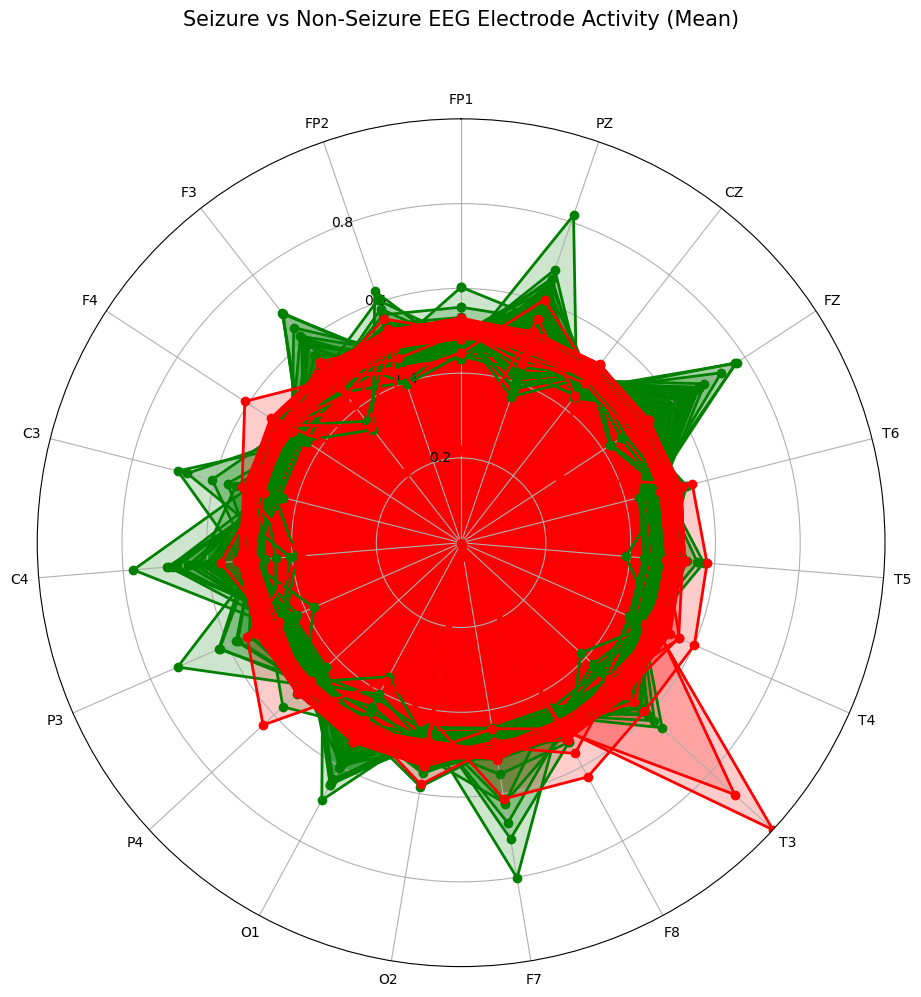

In [124]:
electrode_names = ['FP1', 'FP2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2',
                 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'FZ', 'CZ', 'PZ']


seizure_segments = []
non_seizure_segments = []
for segment in dataset_tr:
    if segment[1] == 1:
        seizure_segments.append(segment[0].iloc[0]) # selecting the mean
    if segment[1] == 0:
        non_seizure_segments.append(segment[0].iloc[0])

print(len(non_seizure_segments))
print(len(seizure_segments))

# Combine both datasets into one list
combined_data = non_seizure_segments + seizure_segments

# Create labels for each segment
labels = (["Non-Seizure"] * len(non_seizure_segments) +
          ["Seizure"] * len(seizure_segments))

# Create colors list - green for non-seizure, red for seizure
colors = (["green"] * len(non_seizure_segments) +
          ["red"] * len(seizure_segments))

# Set alpha values (optional)
alphas = (([0.2] * len(non_seizure_segments)) +
          ([0.2] * len(seizure_segments)))

# Plot all segments on the same radar chart
fig, ax = plot_multiple_sessions_radar(
    combined_data,
    labels=labels,
    electrode_names=electrode_names,
    colors=colors,
    alphas=alphas,
    title="Seizure vs Non-Seizure EEG Electrode Activity (Mean)",
    normalize=True
)

plt.tight_layout()
plt.show()

4160
840


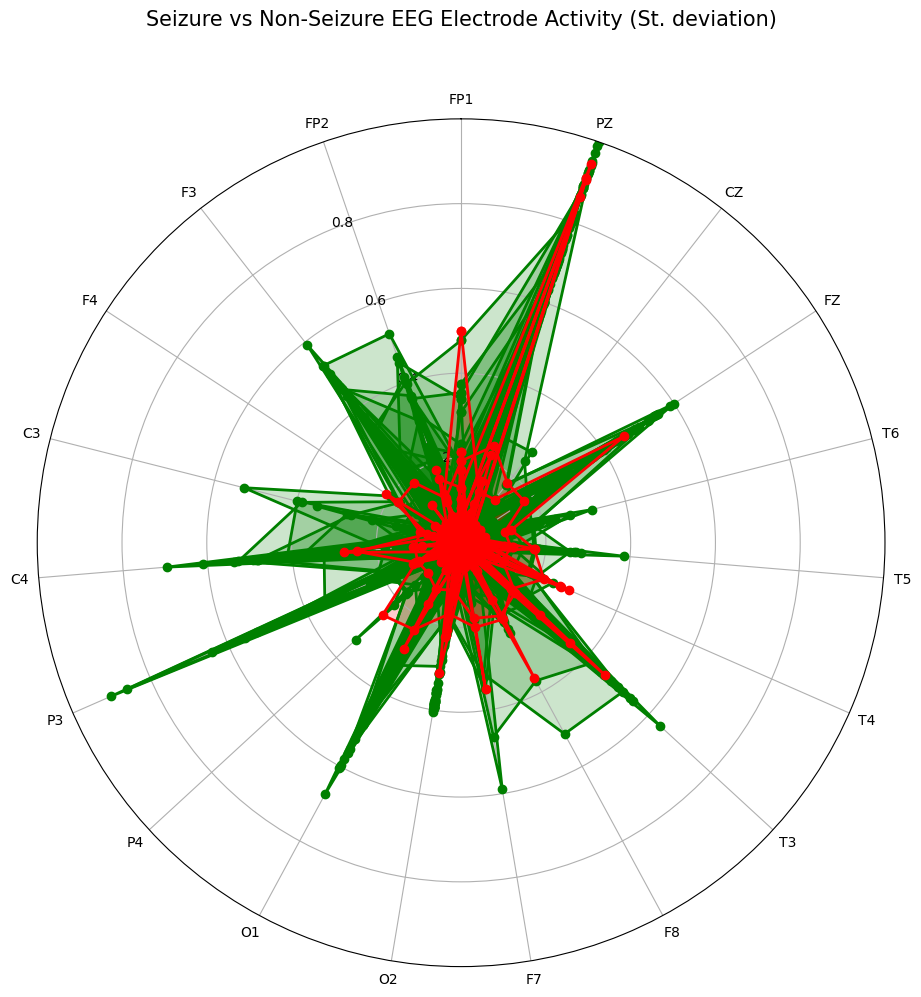

In [125]:
electrode_names = ['FP1', 'FP2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2',
                 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'FZ', 'CZ', 'PZ']


seizure_segments = []
non_seizure_segments = []
for segment in dataset_tr:
    if segment[1] == 1:
        seizure_segments.append(segment[0].iloc[1]) # selecting the std
    if segment[1] == 0:
        non_seizure_segments.append(segment[0].iloc[1])

print(len(non_seizure_segments))
print(len(seizure_segments))

# Combine both datasets into one list
combined_data = non_seizure_segments + seizure_segments

# Create labels for each segment
labels = (["Non-Seizure"] * len(non_seizure_segments) +
          ["Seizure"] * len(seizure_segments))

# Create colors list - green for non-seizure, red for seizure
colors = (["green"] * len(non_seizure_segments) +
          ["red"] * len(seizure_segments))

# Set alpha values (optional)
alphas = (([0.2] * len(non_seizure_segments)) +
          ([0.2] * len(seizure_segments)))

# Plot all segments on the same radar chart
fig, ax = plot_multiple_sessions_radar(
    combined_data,
    labels=labels,
    electrode_names=electrode_names,
    colors=colors,
    alphas=alphas,
    title="Seizure vs Non-Seizure EEG Electrode Activity (St. deviation)",
    normalize=True
)

plt.tight_layout()
plt.show()

4160
840


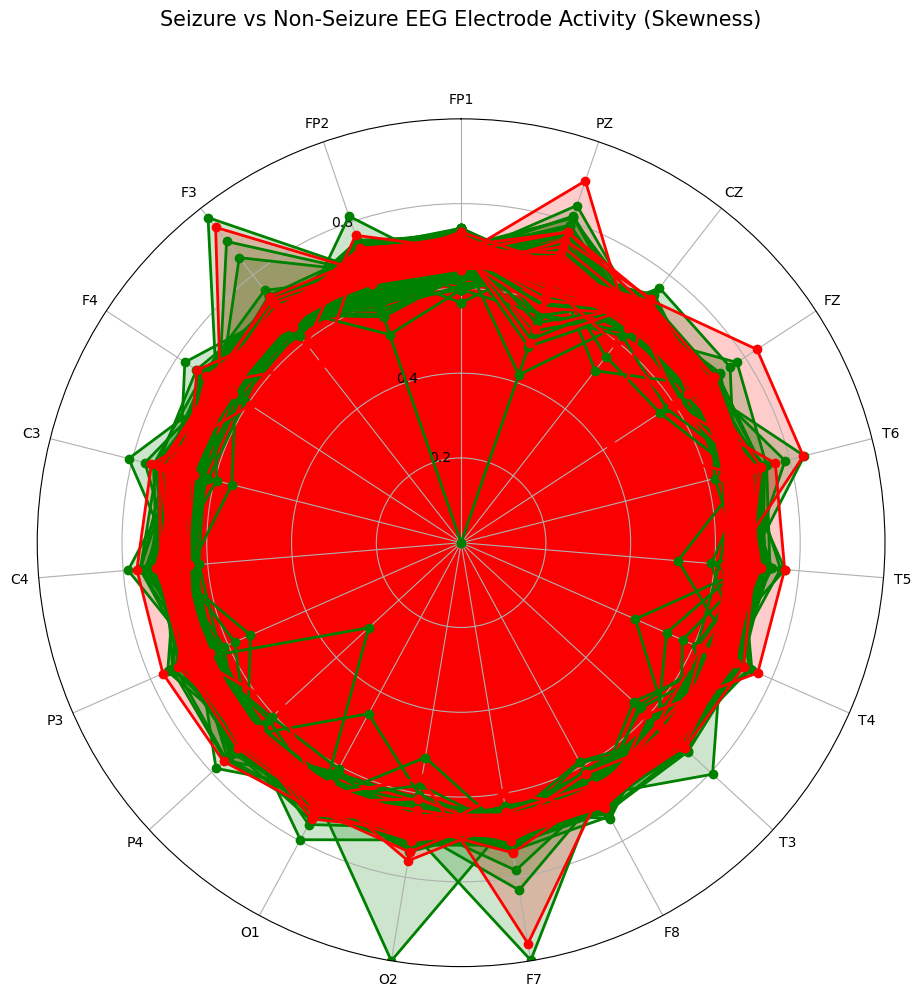

In [128]:
electrode_names = ['FP1', 'FP2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2',
                 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'FZ', 'CZ', 'PZ']


seizure_segments = []
non_seizure_segments = []
for segment in dataset_tr:
    if segment[1] == 1:
        seizure_segments.append(segment[0].iloc[2]) # selecting the skewness
    if segment[1] == 0:
        non_seizure_segments.append(segment[0].iloc[2])

print(len(non_seizure_segments))
print(len(seizure_segments))

# Combine both datasets into one list
combined_data = non_seizure_segments + seizure_segments

# Create labels for each segment
labels = (["Non-Seizure"] * len(non_seizure_segments) +
          ["Seizure"] * len(seizure_segments))

# Create colors list - green for non-seizure, red for seizure
colors = (["green"] * len(non_seizure_segments) +
          ["red"] * len(seizure_segments))

# Set alpha values (optional)
alphas = (([0.2] * len(non_seizure_segments)) +
          ([0.2] * len(seizure_segments)))

# Plot all segments on the same radar chart
fig, ax = plot_multiple_sessions_radar(
    combined_data,
    labels=labels,
    electrode_names=electrode_names,
    colors=colors,
    alphas=alphas,
    title="Seizure vs Non-Seizure EEG Electrode Activity (Skewness)",
    normalize=True
)

plt.tight_layout()
plt.show()

4160
840


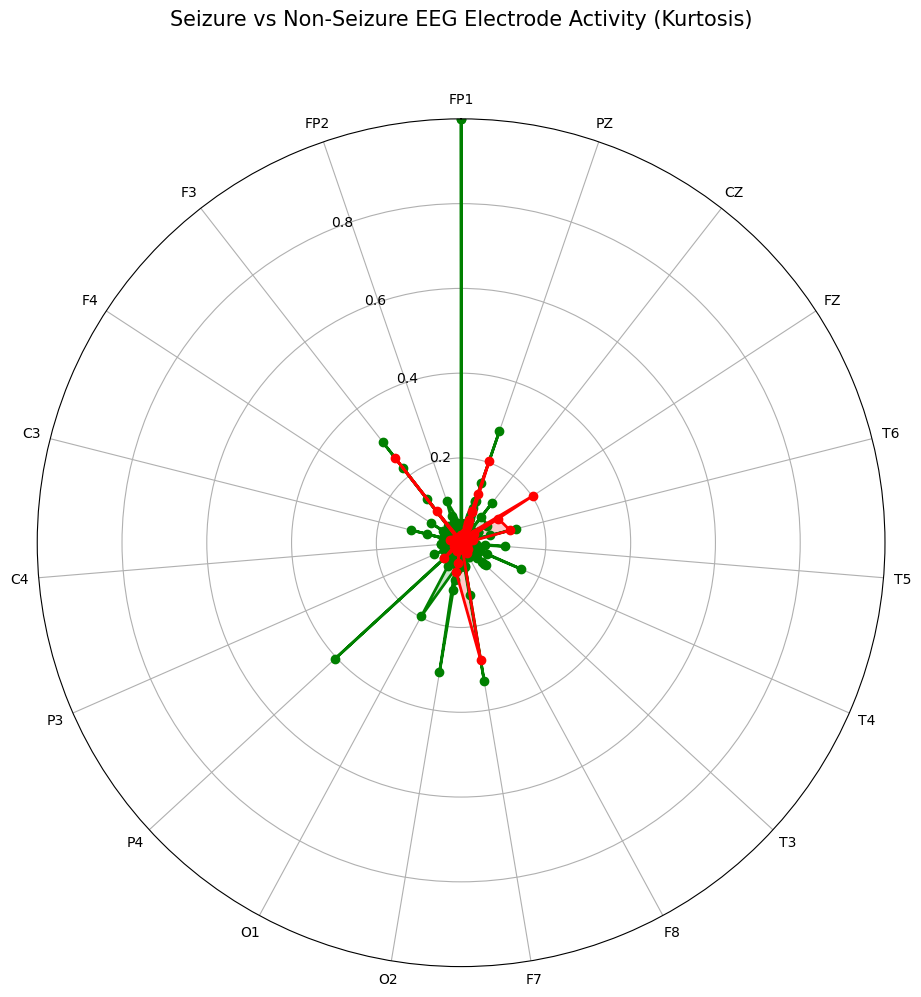

In [129]:
electrode_names = ['FP1', 'FP2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2',
                 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'FZ', 'CZ', 'PZ']


seizure_segments = []
non_seizure_segments = []
for segment in dataset_tr:
    if segment[1] == 1:
        seizure_segments.append(segment[0].iloc[3]) # selecting the kurtosis
    if segment[1] == 0:
        non_seizure_segments.append(segment[0].iloc[3])

print(len(non_seizure_segments))
print(len(seizure_segments))

# Combine both datasets into one list
combined_data = non_seizure_segments + seizure_segments

# Create labels for each segment
labels = (["Non-Seizure"] * len(non_seizure_segments) +
          ["Seizure"] * len(seizure_segments))

# Create colors list - green for non-seizure, red for seizure
colors = (["green"] * len(non_seizure_segments) +
          ["red"] * len(seizure_segments))

# Set alpha values (optional)
alphas = (([0.2] * len(non_seizure_segments)) +
          ([0.2] * len(seizure_segments)))

# Plot all segments on the same radar chart
fig, ax = plot_multiple_sessions_radar(
    combined_data,
    labels=labels,
    electrode_names=electrode_names,
    colors=colors,
    alphas=alphas,
    title="Seizure vs Non-Seizure EEG Electrode Activity (Kurtosis)",
    normalize=True
)

plt.tight_layout()
plt.show()